In [1]:
# adapted from Zijin Gu: https://github.com/zijin-gu/scfc-coupling
import sys
import scipy.io as sio
import numpy as np
import os
import matplotlib.pyplot as plt
from matplotlib.pyplot import figure

cwd = os.getcwd()
data_dir = '/Users/emilyolafson/GIT/stroke-graph-matching/data'
roi_number = 268

def extract_fc_corr():
    fc_dir = data_dir +'/pearson_fc/'
    subj_all = np.genfromtxt(fc_dir + 'subjects.txt', dtype = 'str')
    fc_corr = np.zeros([subj_all.shape[0],roi_number,roi_number])
    n = 0
    for subj in subj_all:
        fccov = sio.loadmat(fc_dir + str(subj))
        fc_corr[n] = fccov['C']
        n += 1
    mdic = {"C": fc_corr}
    sio.savemat(str(data_dir + '/pearson_fc/FCcorr_concat_allsub.mat'), mdic)

def extract_fc_prec():
    fc_dir =data_dir + '/covariance/'
    subj_all = np.genfromtxt(fc_dir + 'subjects.txt', dtype = 'str')
    fc_corr = np.zeros([subj_all.shape[0],roi_number,roi_number])
    n = 0
    trace=[]
    norm=[]
    for subj in subj_all:
        fccov = sio.loadmat(fc_dir + str(subj))
        fc_corr[n] = fccov['C'] # need to use covariance
        n = n+1
        
    # regularized precision calculation
    min_rmse = 1e5
    opt_gamma = 0
    allrmse=[]
    
    for gamma in np.linspace(0, 1,50): #for all gamma values
        inverse = []
        reg_inv = []
        
        for i in range(subj_all.shape[0]): #calculate the unregularized inverse and regularized inverse for a given gamma
            np.fill_diagonal(fc_corr[i],1)

            inverse.append(np.linalg.inv(fc_corr[i]))
            reg_inv.append(np.linalg.inv(fc_corr[i] + gamma*np.eye(roi_number)))

        group_prec = np.mean(inverse, axis=0) #calculate the mean unregularized inverse across subjects
        
        diff = []

        # for each subject, calculate the difference between the regularized inverse and group average unregularized inverse.
        for i in range(subj_all.shape[0]):
            diff.append(np.linalg.norm(reg_inv[i][np.triu_indices(roi_number,1)] - group_prec[np.triu_indices(roi_number,1)]))
        rmse = np.mean(diff) #mean difference across subjects
        allrmse.append(rmse)

        if rmse < min_rmse:
            min_rmse = rmse
            opt_gamma = gamma 
            

    fc_prec = np.zeros([subj_all.shape[0],roi_number,roi_number])
    
    #now calculate regularized inversion matrices based on optimal gamma (should be lambda).
    for i in range(subj_all.shape[0]):
        fc_prec[i] = np.linalg.inv(fc_corr[i] + opt_gamma*np.eye(roi_number))

    mdic = {"C": fc_prec, "gamma": opt_gamma, "rmse":allrmse, "sub_sessID": subj_all}
    output_dir =data_dir + '/precision/'

    sio.savemat(output_dir + 'FCprec_concat_allsub.mat', mdic)
    
for sess in range(0,1):
    extract_fc_prec()
    #extract_fc_corr()
    
    

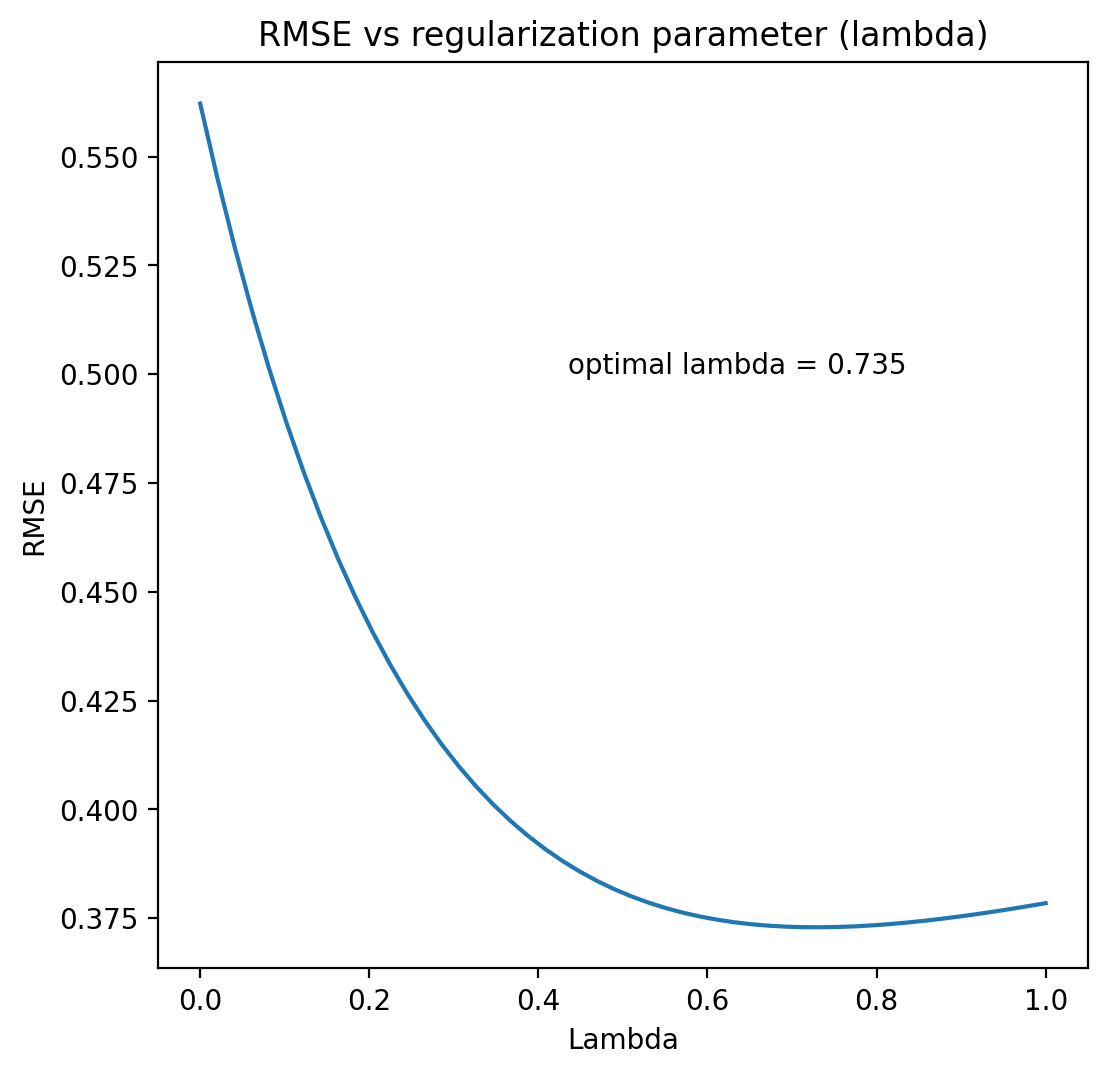

In [2]:
cwd = os.getcwd()
data_dir = '/Users/emilyolafson/GIT/stroke-graph-matching/data'
fc_dir =data_dir + '/precision/'
output_prec = sio.loadmat(fc_dir + 'FCprec_concat_allsub.mat')
rmse = output_prec['rmse'] 
opt_gamma = output_prec['gamma'] 
gridsearch=np.linspace(0,1,50)

figure(num=None, figsize=(6, 6), dpi=200, facecolor='w', edgecolor='k')

plt.plot(gridsearch,rmse.transpose())
plt.ylabel('RMSE')
plt.xlabel('Lambda')
plt.title('RMSE vs regularization parameter (lambda)')
plt.text(opt_gamma-0.3, 0.5, 'optimal lambda = ' + str(round(opt_gamma[0][0],3)))
results_dir = '/Users/emilyolafson/GIT/stroke-graph-matching/apaper/figs/'
plt.savefig(results_dir + 'optimal_gamma.png')